# Import the Libraries and Dependencies

In [89]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Download the S&P 500 dataset

#### Downloading and Importing Dependencies

In [90]:
%pip install yfinance
import yfinance as yf
import datetime

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Fetching the data from FRED

In [91]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
df = yf.download('^GSPC', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [92]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2022-12-23,3815.110107,3845.800049,3797.010010,3844.820068,3844.820068,2819280000
2022-12-27,3843.340088,3846.649902,3813.219971,3829.250000,3829.250000,3030300000
2022-12-28,3829.560059,3848.320068,3780.780029,3783.219971,3783.219971,3083520000


# Preprocess the data

In [93]:
stock_symbol = '^GSPC'  # Choose a stock symbol from the dataset
stock_data = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# Split the data into Training and Testing sets

In [94]:
train_data = scaled_data[:int(0.8 * len(stock_data))]
test_data = scaled_data[int(0.8 * len(stock_data)):]

# Create input sequences for the LSTM Model

In [95]:
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        x.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(x), np.array(y)

In [96]:
seq_length = 20  # Adjust the sequence length as needed
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# Build the LSTM Model

In [97]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=64))
model.add(Dropout(0.1))
model.add(Dense(units=1))

# Compile the Model

In [98]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Define Early Stopping Callback

In [99]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model

In [100]:
history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/200
65/65 [==============================] - 4s 22ms/step - loss: 0.0038 - val_loss: 8.5873e-04
Epoch 2/200
65/65 [==============================] - 1s 9ms/step - loss: 3.6193e-04 - val_loss: 9.3606e-04
Epoch 3/200
65/65 [==============================] - 1s 9ms/step - loss: 3.0942e-04 - val_loss: 8.2707e-04
Epoch 4/200
65/65 [==============================] - 1s 9ms/step - loss: 2.8311e-04 - val_loss: 9.4988e-04
Epoch 5/200
65/65 [==============================] - 1s 9ms/step - loss: 2.5636e-04 - val_loss: 0.0013
Epoch 6/200
65/65 [==============================] - 1s 10ms/step - loss: 3.0390e-04 - val_loss: 7.9676e-04
Epoch 7/200
65/65 [==============================] - 1s 11ms/step - loss: 2.3509e-04 - val_loss: 9.0273e-04
Epoch 8/200
65/65 [==============================] - 1s 11ms/step - loss: 2.5687e-04 - val_loss: 7.3054e-04
Epoch 9/200
65/65 [==============================] - 1s 11ms/step - loss: 2.7224e-04 - val_loss: 7.4052e-04
Epoch 10/200
65/65 [====================

# Make prediction on the test data

In [101]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

20/20 [==============================] - 1s 4ms/step


# Evaluate the Model

In [102]:
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 72.90778872167577


# Plot the training and validation loss

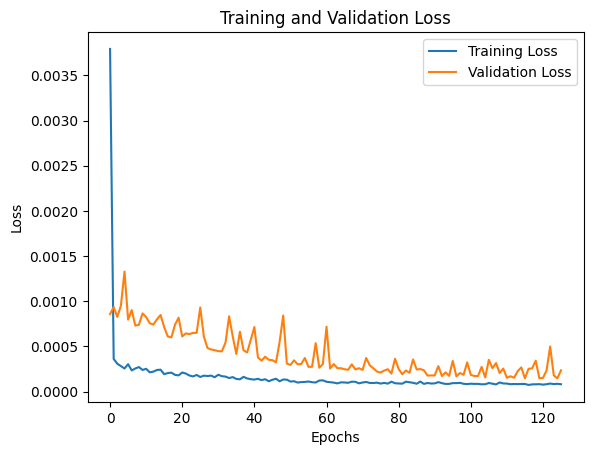

In [103]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the actual and predicted stock prices

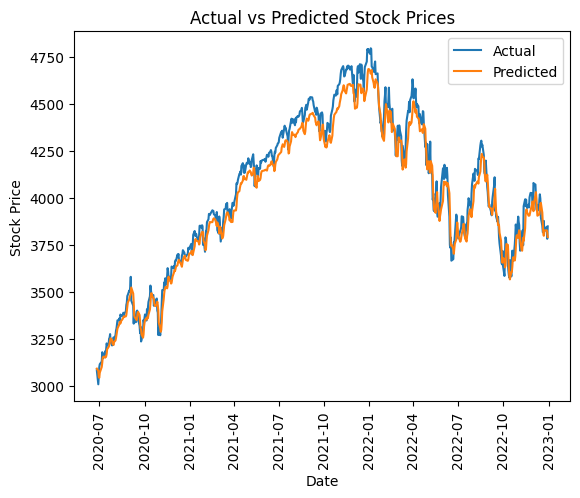

In [104]:
plt.plot(df.index[int(0.8 * len(stock_data)) + seq_length + 1:], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(df.index[int(0.8 * len(stock_data)) + seq_length + 1:], predictions, label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=90)
plt.legend()
plt.show()